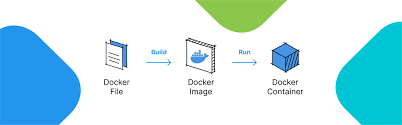

## ¿Qué es Dockerfile y cómo crearlo?

Dockerfile es un fichero que indica a Docker las instrucciones a seguir para incluir todo lo necesario en la imagen: la aplicación, los programas que necesita, la instalación de las librerías, etc.

Al final y al cabo, lo que hay detrás de Docker es un sistema Linux. Por tanto, tendremos que instalar los programas que necesitemos, incluir nuestro código e indicar a Docker que lo ejecute.

Para ello, Docker cuenta con varios comandos que permiten saber qué elementos incluir en nuestra imagen. Los verbos más típicos son FROM, COPY, RUN, CMD y ENTRYPOINT.

### Crear un Dockerfile: FROM

Este verbo indica la imagen base sobre la cual vamos a partir. Como he dicho antes, Docker se basa en instalar en un sistema Linux todo lo que necesitemos para ejecutar nuestro código. ¿Significa esto que vas a tener que instalar Python, Tnesorflow, etc. desde línea de comandos? Pues no.

Y es que la comunidad suele crear imágenes que incluyen ya contenido genérico. Por ejemplo, si usas Python hay imágenes que ya tienen Python instalado. Incluso, hay imágenes que ya tienen todo lo necesario para que ejecutes Tensorflow.

Para encontrar estas imágenes lo más común suele ser buscar la imagen en el repositorio de imágenes de Docker [dockerhub](https://hub.docker.com/). Si buscas [“tensorflow”](https://hub.docker.com/r/tensorflow/tensorflow), por ejemplo, encontrarás la imagen oficial de Tensorflow (enlace).

Por ejemplo, supongamos que hemos creado un modelo de Machine Learning en Python y hemos creado una API con FastAPI.

Si buscamos en la documentación de [FastAPI](https://fastapi.tiangolo.com/deployment/docker/) verás que indican que esta [imagen Docker](https://hub.docker.com/r/tiangolo/uvicorn-gunicorn-fastapi) incluye todo lo necesario para usar Fast API.

Ahora es tan simple como:
> FROM tiangolo/uvicorn-gunicorn-fastapi

Pero... ¿y si quiero algo adicional que no esta en esa imagen?

### Dockerfile: RUN

La instrucción RUN ejecutará un comando en consola. Esto nos servirá para instalar nuevo software que necesitemos pero que la imagen de la que partimos no incluye. Por ejemplo, esto puede darse si quieres acceder a una base de datos.

RUN puede tener dos formas diferentes:

1. RUN comando : ejecuta el comando el shell.
2. RUN [ejecutable parametro1 parametro2] . Permite pasar parámetros a la ejecución.

Por ejemplo, si queremos contectarnos a PostgreSQL, tendremos que instalar el paquete libq-dev. Para ello nuestro Dockerfile tendría que incluir la siguiente instrucción:

> RUN apt-get update

> RUN apt-get install -y libpq-dev 

Asimismo para no incluir cada línea en una instrucción diferente, podríamos juntarlas en una única instrucción de la siguiente forma:

```
RUN apt-get update \
    && apt-get install -y libpq-dev
```

En nuestro caso usaremos el comando RUN para instalar las dependencias de nuestra aplicación del fichero requirements.txt.

> RUN pip install -r requirements.txt

### Dockerfile: COPY, ADD y WORKDIR

Tanto COPY como ADD sirven para añadir contenido a nuestro Dockerfile, aunque ADD ofrece más opciones que COPY. Y es que, mientras que COPY únicamente sirve para copiar ficheros en local, con ADD puedes añadir ficheros de una URL.

Ademas, si añades un fichero local comprimido (como un fichero tar.gz), ADD lo descomprimirá en una carpeta nueva.

Aunque ADD parezca muy superior a COPY, a menos que vayas a usar alguna de las funcionalidades de ADD, Docker recomienda el uso de COPY.

Asimismo, tanto ADD como COPY toman dos parámetros:

1. Ruta de origen: indica la ruta donde se encuentra el fichero que quieres copiar.
2. Ruta de destino: ruta en la que quieres “pegar” el fichero. Si no quieres pegarlo en una ruta específica, puedes indicar que se pegue en /, de tal forma que el elemento se pegue en el Working Directory.

Asimismo, para indicar el Working Directory usaremos el verbo WORKDIR. La instrucción WORKDIR permite indicar dónde se ejecutarán las funciones RUN, CMD, ENTRYPOINT, COPY y ADD que vengan a continuación. Asimismo, en caso de que sea necesario, es posible cambiar el WORKDIR varias veces en un mismo Dockerfile 

Siguiendo el ejemplo, supongamos que tenemos la siguiente estructura:

```.
├── app
│   └── main.py
│
├── Dockerfile
│
└── requirements.txt
```

Además, el fichero main.py podria ser algo asi...

In [ ]:
from fastapi import FastAPI, Request
from fastapi.responses import HTMLResponse, StreamingResponse
from fastapi.templating import Jinja2Templates
import pandas as pd
import matplotlib.pyplot as plt

app = FastAPI()

templates = Jinja2Templates(directory="templates")

@app.get("/", response_class=HTMLResponse)
async def inicio(request: Request):
    return templates.TemplateResponse("index.html", {"request": request})

@app.get("/obtener-iris")
def obtener_iris():
    url ='https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv'
    iris = pd.read_csv(url)
    return iris.to_dict(orient='records')

@app.get("/graficar-iris")
def graficar_iris():
    url ='https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv'
    iris = pd.read_csv(url)

    plt.scatter(iris['sepal_length'], iris['sepal_width'])
    plt.savefig('iris.png')
    archivo = open('iris.png', mode="rb")

    return StreamingResponse(archivo, media_type="image/png")


Así pues, tendremos que incluir nuestro fichero en nuestra imagen Docker. Para ello simplemente incluiríamos la siguiente instrucción:

```
# Creo la carpeta
RUN mkdir -p app

# Pego la carpeta
COPY ./app app
```

y por último.

### Dockerfile: EXPOSE, ENTRYPOINT y CMD.

Si tu código va a estar escuchando en un puerto, EXPOSE te permite definir el puerto en el que va a estar escuchando tu aplicación.

Por otro lado, ENTRYPOINT permite definir el comando que se va a ejecutar cuando se lance la imagen Docker. Por su parte, CMD permite definir los argumentos que vaya a usar ENTRYPOINT.

Por ejemplo, supongamos que vamos a ejecutar nuestra API de FastAPI, y queremos que el usuario pueda definir el host y el puerto en el que se ejecuta. Es por ello que usaremos la instrucción CMD. Más en concreto, al instrucción será la siguiente:

> CMD ["uvicorn", "app.main:app", "--host", "0.0.0.0", "--port", "8080"]

### Terminando el Dockerfile

Considerando todo lo anterior, nuestro Dockerfile tendrá el siguiente aspecto:

```
FROM tiangolo/uvicorn-gunicorn-fastapi
COPY requirements.txt .
RUN pip install -r requirements.txt
RUN mkdir -p app
COPY ./app app
EXPOSE 8080
CMD ["uvicorn", "app.main:app", "--host", "0.0.0.0", "--port", "8080"]
```

Ahora, tendremos que guardarlo como un fichero sin extensión. El fichero deberá llamarse ``Dockerfile`` (sino no servirá).

Con esto, ya tenemos nuestro Dockerfile listo y podremos crear nuestra [imagen Docker](3-docker_imagen.ipynb)